# Notebook for Authorship Attribution using multichanels

In [49]:
#python basic libs
import os;
from os.path import join as pathjoin;
import zipfile;

import re;
import random;
import json;
from collections import defaultdict, Counter;
from pprint import pprint
from time import time

In [2]:
%matplotlib inline
#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;

In [53]:
#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import feature_selection;

#preprocessing and transformation
from sklearn import preprocessing;
from sklearn import decomposition;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics

#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score;

In [4]:
import spacy;
import gensim
import logging
from gensim.models import KeyedVectors
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [5]:
from IPython.display import Markdown, display, HTML

In [6]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format
sns.set(color_codes=True);

In [8]:
import platform;
import sklearn;
import scipy;

Markdown(
    "|%-15s|%-65s|\n"%("PACK","VERSION") +
    "|%-15s|%-65s|\n"%('-'*15,'-'*65) +
    ('\n'.join(
    "|%-15s|%-45s| " % (pack, version.strip())
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn','Spacy','Gensim'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__, spacy.__version__, gensim.__version__])

)))

|PACK           |VERSION                                                          |
|---------------|-----------------------------------------------------------------|
|SO             |Darwin-18.5.0-x86_64-i386-64bit              | 
|NumPy          |1.15.4                                       | 
|SciPy          |1.1.0                                        | 
|Scikit-Learn   |0.20.1                                       | 
|Seaborn        |0.9.0                                        | 
|Spacy          |2.0.16                                       | 
|Gensim         |3.4.0                                        | 

In [9]:
baseDir = '/Users/joseeleandrocustodio/GitHub/PANAA2018/data/';
corpusTraining    = 'pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02';
corpusEvaluation = 'pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20';
corpusEach1 = 'AvaliacaoPT';

currentCorpus = corpusEvaluation;

inputDir= pathjoin(baseDir,currentCorpus);
outputDir= pathjoin(baseDir,'out');
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

In [10]:
import pan
import sklearnExtensions
from sklearnExtensions import DenseTransformer

In [11]:
problems = pan.readCollectionsOfProblems(inputDir);

In [12]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,[[hairdryer currently turned on high.\n ...,20,UTF-8,en,problem00001,[[looked a bit confused not sure how to answer...
1,"[[hey, perhaps he'd like to test that authorit...",15,UTF-8,en,problem00002,"[[, he pulled away. \n\n""I'm sorry, George."" \..."
2,[[MORE BLISSED OUT AT THE VERY FACT THAT THEY ...,10,UTF-8,en,problem00003,"[[I rasp, and I can actually hear the tirednes..."
3,[[to feel Link inside of him anyways. Ever sin...,5,UTF-8,en,problem00004,[[the swish of his third and incomplete spell ...
4,[[Du coin de l'œil il pouvait voir le sourire ...,20,UTF-8,fr,problem00005,"[[put se recoucher l'esprit tranquille, s'emmi..."
5,"[[ai pas vu s'agrandir et s'affirmer, jusqu'à ...",15,UTF-8,fr,problem00006,[[Marcus l’avait encore une fois humilié.Alors...
6,"[[qui allait tout revomir ensuite, Varus serra...",10,UTF-8,fr,problem00007,"[[, maintenant que ses jambes étaient grandes ..."
7,[[même expérience que toi par rapport aux vamp...,5,UTF-8,fr,problem00008,[['elle aimait en secret.\n\nUn jaune éclatant...
8,[[aveva usato anche uno squallidissimo doppio ...,20,UTF-8,it,problem00009,"[[Se Harry e Draco fossero stati a Hogwarts, p..."
9,[[\n\n\n\n\n\n\n\n'Sarai mio.'\n\n\n\n\n\n\n\n...,15,UTF-8,it,problem00010,"[[stesso e non aveva un buon odore, per quanto..."


In [13]:
pd.DataFrame(problems).groupby(['language','candidates_folder_count']).count().reset_index()

,language,candidates_folder_count,candidates,encoding,problem,unknown
0,en,5,1,1,1,1
1,en,10,1,1,1,1
2,en,15,1,1,1,1
3,en,20,1,1,1,1
4,fr,5,1,1,1,1
5,fr,10,1,1,1,1
6,fr,15,1,1,1,1
7,fr,20,1,1,1,1
8,it,5,1,1,1,1
9,it,10,1,1,1,1


In [23]:
def tag(p):
    df = pd.concat([
            pd.DataFrame(p['candidates']),
            pd.DataFrame(p['unknown'])]
    );
    df.columns=['text','candidate','fandom'];
    df['text_char_length'] = df['text'].apply(lambda x:len(x))
    df['text_word_length'] = df['text'].apply(lambda x:len(re.findall(r'\b\w+\b',x)))

    #df.drop(columns=['fandom'],inplace=True)
    df['set'] = ['train']*len(p['candidates']) + ['val']*len(p['unknown'])
    df['problem-name'] = p['problem'];
    df['language'] = p['language'];
    return df;
df = pd.concat([tag(p) for p in problems])

p1 = pd.pivot_table(df,index=['problem-name'], columns='set', values=['text_char_length','text_word_length'],aggfunc='mean')

def a(x):
    c= x[['text','candidate']].groupby('candidate').count().reset_index();
    
    return pd.Series({
     'docs_per_author': c['text'].mean()
    })
    
p2 = df.groupby(['problem-name','set']).apply(a).reset_index().pivot(index='problem-name',columns='set')

corpus_stats = pd.merge(p1,p2,on='problem-name')

In [24]:
def readBaseline():
    baselines = ['svm_evaluation'];
    baselineResults  = [json.load(open('./outputEvaluation/'+f+'/out.json')) for f in baselines];
    
    #converting the overall into a row
    baselineResults2 = []
    for p,b in zip(baselineResults,baselines):
        t = p['problems'];
        t.append({'problem-name':'overall', 'macro-f1':p['overall_score']})
        for tt in t:
            tt['method'] = b;
        baselineResults2 +=t;
    
    baselineResults2 = pd.DataFrame(baselineResults2);
    return baselineResults2;

baselineResults = readBaseline()


In [25]:
p3 = baselineResults[['problem-name','method','macro-f1']].pivot(index='problem-name',columns='method')

In [26]:
pd.merge(corpus_stats,p3,on='problem-name')\
    .style.background_gradient(cmap=sns.light_palette("gray", as_cmap=True),axis=0)

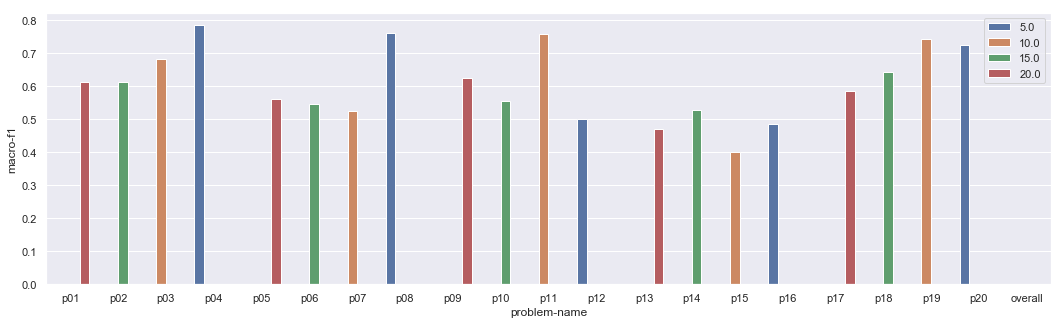

In [27]:
def a():
    df = pd.merge(
        pd.DataFrame(baselineResults),
        pd.DataFrame(problems)[['problem','candidates_folder_count','language']].rename(columns={'problem':'problem-name'}),
        on='problem-name',
        how='left'
    );
    df['problem-name'] = df['problem-name'].apply(lambda x: x.replace('problem000','p'))
    plt.figure(figsize=(18,5))
    sns.barplot(data=df, x='problem-name',y='macro-f1', hue='candidates_folder_count');
    plt.legend(loc=1);
    #plt.title("Macro-F1 score")
a();

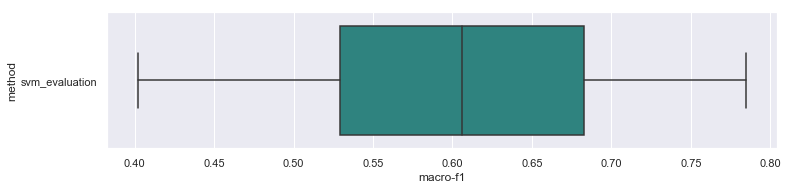

In [28]:
def a():
    df = pd.DataFrame(baselineResults);
    df['problem-name'] = df['problem-name'].apply(lambda x: x.replace('problem000',''))
    plt.figure(figsize=(12,2.5))
    sns.boxplot(data=pd.DataFrame(baselineResults),x='macro-f1', y='method',whis="range", palette="viridis");
a();

In [29]:
def upsample_text(texts, labels, min_doc_sample = 10):
    texts = texts.copy();
    labels = labels.copy();
    counter = Counter(labels);
    doc_per_label = max(max(counter.values()),min_doc_sample);
    
    new_texts  = [];
    new_labels = [];
    
    for label, cnt in counter.items():
        temp_texts = [t for t,l in zip(texts,labels) if l == label];
        
        while cnt < doc_per_label:
            texts_sizes = np.array([len(t) for t in temp_texts]);
            #in descending order;
            temp_texts = np.array(temp_texts)[np.argsort(-texts_sizes)].tolist();
            
            text = temp_texts.pop(0);
            l = int(0.25*len(text));
            temp_texts.append(text[:(len(text)-l)])
            temp_texts.append(text[l:]);
            
            cnt = len(temp_texts)
            
        
        new_texts  += temp_texts;
        new_labels += [label] * cnt;
        
    
    indexes = np.arange(len(new_texts));
    np.random.shuffle(indexes);
        
    return np.array(new_texts)[indexes].tolist(), np.array(new_labels)[indexes].tolist()
    
#train_docs, train_labels = upsample_text(train_docs, train_labels);

In [30]:
def eval_measures(test_labels, predictions):
    gt = {i:label for i,label in enumerate(test_labels) }
    pred = {i:label for i,label in enumerate(predictions) }
    
    ## keep pan original eval code
    actual_authors = list(gt.values())
    encoder = preprocessing.LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')


    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        labels=list(set(gold_author_ints))
        # Exclude the <UNK> class
        f1 = metrics.f1_score(gold_author_ints, silver_author_ints,labels,average='macro')
        precision = metrics.precision_score(gold_author_ints, silver_author_ints,labels,average='macro')
        recall = metrics.recall_score(gold_author_ints, silver_author_ints,labels,average='macro')
        accuracy = metrics.accuracy_score(gold_author_ints,silver_author_ints)

    return f1,precision,recall,accuracy

# Main Logic

In [69]:
def runModel(problem, pipeline, parameters, probCut=0.055,upsample=0, n_jobs=-1,verbose=False):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']), end=' ')
    
    train_docs, train_labels, _ = zip(*problem['candidates'])
    test_docs, test_labels, _   = zip(*problem['unknown'])
    
    if upsample> 0:
        train_docs, train_labels = upsample_text(list(train_docs), list(train_labels),min_doc_sample=upsample);
    
    grid_search = GridSearchCV(pipeline,
                               parameters,cv=3,
                               iid=False, n_jobs=n_jobs, verbose=verbose, scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels);
    grid_search.best_estimator_.fit(train_docs, train_labels)
    
    print("Gridsearh %0.3fs" % (time() - t0))

    test_pred      =grid_search.predict(test_docs);
    test_pred_proba=grid_search.predict_proba(test_docs);
    dist = test_pred_proba.std(axis=1);
    
    test_pred_original = test_pred.copy();
    
    test_pred[dist <= probCut] = '<UNK>';
   
    #find the best cut off
    def thresh(dist,pred,p):
        t = pred.copy();
        t[dist < p] = '<UNK>';
        return t;
    q=np.percentile(dist.flatten(),q=np.linspace(0,100,101));
    f1=[eval_measures(test_labels,thresh(dist,test_pred_original,p))[0] for p in q];
    distmax = q[f1 == max(f1)][0]
    
    f1,precision,recall,accuracy = eval_measures(test_labels,test_pred)
    report = metrics.classification_report(test_labels,test_pred, output_dict=True);
    print("Best score: %0.3f - Test score: %0.3f - in %0.3fs" % (grid_search.best_score_, f1, time() - t0))
    best_parameters = grid_search.best_estimator_.get_params()
    print("'"+problem['language']+"':{")
    for param_name in sorted(parameters.keys()):
        print("\t'%s': %r," % (param_name, best_parameters[param_name]))
    print("},")
    
    return {
                'problem'  : problem['problem'],
                'f1'       : round(f1,4),
                'accuracy' : round(accuracy,4),
                'report'   : report,
                'best_cut' : round(distmax,4)
                
        }, grid_search.cv_results_,best_parameters;

In [70]:
def runGrid(funct):
    result = [];
    cv_result = [];
    best_parameters = [];
    for problem in problems:
        r, c, b = funct(problem);
        result.append(r);
        cv_result.append(c);
        b['problem'] = problem['problem'];
        best_parameters.append(b);
    return {'result':result,'cv':cv_result,'best_params':best_parameters};

In [71]:
allResults = {};

In [72]:
def runCharModel(problem):
    pipeline = Pipeline([
        ('vect',CountVectorizer(analyzer='char',
                ngram_range=(2,5),
                min_df=0.01,
                lowercase=False,
                dtype=np.float64)),
        ('weight',TfidfTransformer(
                smooth_idf=True,
                sublinear_tf=True,
                norm='l1',
                )),
        ('scaler', preprocessing.MaxAbsScaler()),
        #('selection',feature_selection.SelectPercentile(percentile=99)),
        ('dense',DenseTransformer()),
        ('pca'  ,decomposition.PCA(0.99)),
        ('clf', linear_model.LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((2,4),(2,5)),
        'vect__lowercase':(True,False),
        'weight__smooth_idf':(True,False),
        'weight__sublinear_tf':(True,False),
    }
    return runModel(problem,pipeline, parameters,upsample=0,n_jobs=1,verbose=True)

In [73]:
allResults['char'] =runGrid(runCharModel);


Problem: problem00001,  language: en,  Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  2.7min finished


Gridsearh 163.570s
Best score: 0.843 - Test score: 0.000 - in 164.951s
'en':{
	'vect__lowercase': False,
	'vect__ngram_range': (2, 4),
	'weight__smooth_idf': True,
	'weight__sublinear_tf': True,
},

Problem: problem00002,  language: en,  Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.8min finished


Gridsearh 115.923s
Best score: 0.855 - Test score: 0.000 - in 118.108s
'en':{
	'vect__lowercase': True,
	'vect__ngram_range': (2, 5),
	'weight__smooth_idf': True,
	'weight__sublinear_tf': True,
},

Problem: problem00003,  language: en,  Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  1.2min finished


Gridsearh 75.203s
Best score: 0.942 - Test score: 0.000 - in 76.385s
'en':{
	'vect__lowercase': True,
	'vect__ngram_range': (2, 5),
	'weight__smooth_idf': True,
	'weight__sublinear_tf': True,
},

Problem: problem00004,  language: en,  Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   34.5s finished


Gridsearh 35.752s
Best score: 0.873 - Test score: 0.000 - in 36.363s
'en':{
	'vect__lowercase': True,
	'vect__ngram_range': (2, 5),
	'weight__smooth_idf': True,
	'weight__sublinear_tf': True,
},

Problem: problem00005,  language: fr,  Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 